### Importing Dependencies and packages

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import re
import pandas as pd
import shutil
import pickle

### Exploring the image dataset

In [2]:
# Getting the files in the train dataset
filepaths = os.listdir('train')

In [ ]:
pattern = r"^[^_]*"
imagecount = {"apple": 0,"banana": 0,"orange": 0, "mixed": 0}

for i in filepaths:
    match = re.match(pattern, i)
    if match:
        result = match.group()
        if (result != '.DS'):
            imagecount[result] += 1

    else:
        result = None

<BarContainer object of 4 artists>

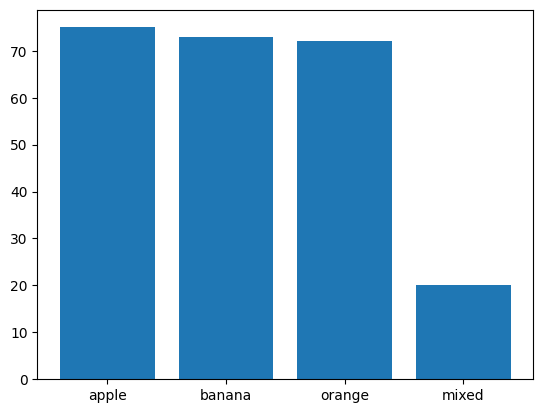

In [ ]:
plt.bar(imagecount.keys(),imagecount.values())

It seems like the mixed class is very inbalanced, we can do image augmentation to improve the split

### Creating a base cnn model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

##### Generating Datasets

In [ ]:
def make_folders(main_dir):
    subDirectories = ['apple','banana','orange','mixed']
    if not os.path.exists(main_dir):
        os.mkdir(main_dir)
    for dir_name in subDirectories:
        sub_dir_path = os.path.join(main_dir, dir_name)
        if not os.path.exists(sub_dir_path):
            os.mkdir(sub_dir_path)

In [ ]:
make_folders("train_sorted")
# Creating an augmentation folder for the sorted augmented photoss
for i in filepaths:
    match = re.match(pattern, i)
    if match:
        result = match.group()
    shutil.copy("train/" + i, "train_sorted/" + result)


In [ ]:
# Inputing images using ImageDataGenerator without augmentation to get baseline
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

def generateTrainValidSets(datagen):
    trainDataSet = datagen.flow_from_directory(
        target_size=(image_height, image_width),
        directory=r"train_sorted",
        subset = "training",
        class_mode = "categorical",
        shuffle = True,
        batch_size = 8
    )

    validDataSet = datagen.flow_from_directory(
        target_size=(image_height, image_width),
        directory=r"train_sorted",
        subset = "validation",
        class_mode = "categorical",
        shuffle = True,
        batch_size = 8
    )

    return trainDataSet, validDataSet

trainDataSet,validDataSet = generateTrainValidSets(datagen)

Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.


In [ ]:
class_indices = trainDataSet.class_indices
print("Class Indices:", class_indices)

Class Indices: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}


##### Model Fitting

In [ ]:
# Defining Number of classes and image input size
num_classes = 4
image_height, image_width = (224,224)

In [ ]:
firstmodel = Sequential()

firstmodel.add(Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
firstmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
firstmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
firstmodel.add(Flatten())
firstmodel.add(Dense(32, activation='relu'))
firstmodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
firstmodel.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
# Training was done in Google Colab 
# num_epochs = 10
# history = basemodel.fit(
#     trainDataSet,
#     steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
#     epochs = num_epochs,
#     validation_data = validDataSet,
#     validation_steps = validDataSet.samples // validDataSet.batch_size,
#     verbose = 1
# )

Epoch 1/10


: 

Model training was done in Google Colab

In [5]:
with open('first_model_history.pkl', 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

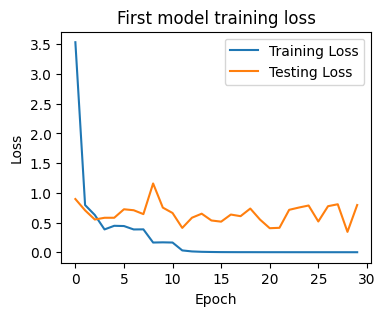

In [10]:
train_loss = history_loaded['loss']
test_loss = history_loaded['val_loss']

plt.figure(figsize=(4, 3))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("First model training loss")
plt.legend()

### Strategies to improve model
1. Adding dropout layer to the classification layer
2. Remove Outliers spotted earlier
3. Image augmentation
4. Account for imbalance dataset by give more weight to the imbalance dataset

#### 1. Adding dropout layers, max pooling and regularization for the last layer to prevent overfitting

In [ ]:
# Calling the Sequential function
basemodel = Sequential()

# Add the convolutional base
basemodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
basemodel.add(Conv2D(64, (3, 3), activation='relu'))
basemodel.add(Conv2D(128, (3, 3), activation='relu'))

# Add the classifier on top
basemodel.add(Flatten())
basemodel.add(Dense(256, activation='relu'))
basemodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
basemodel.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### 2. Removing outliers

##### Checking for Outliers

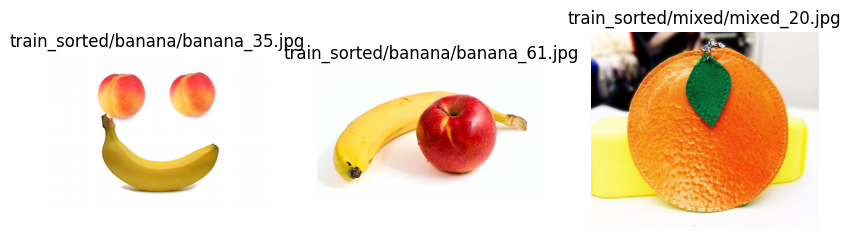

In [ ]:
# Showing the images that are potential outliers or wrongly labelled
wrongImageList = ["train_sorted/banana/banana_35.jpg","train_sorted/banana/banana_61.jpg","train_sorted/mixed/mixed_20.jpg"]

# Plotting the images
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

for i,filepath in enumerate(wrongImageList):
    image = mpimg.imread(filepath)
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(filepath)

By doing visual inspection of the images,

1. banana_35
2. banana_61
3. mixed_20

These are the few images that could be corrected to improve the model's training

##### Doing UMAP to identify any outliers in the dataset

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
# Getting the labels for the images
labeldict = {"apple" : 0 ,"orange" : 1 ,"banana" : 2 ,"mixed" : 3 }
labels = []
for i in filepaths:
    match = re.match(pattern, i)
    if match:
        result = match.group()
        labels.append(labeldict[result])

In [ ]:
# Load pre-trained VGG16 model for feature extraction
model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224)) #VGG16 input size
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    return flattened_features


In [ ]:
# Extract features from all images in the dataset
features_list = [extract_features("train/" + img_path, model) for img_path in filepaths]

# Standardize features
features = np.array(features_list)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



1/1 [==============================] - 0s 322ms/step


c:\Users\Calvin\anaconda3\envs\gdipsa\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 381ms/step


In [ ]:
# Perform UMAP
umap_results_3d = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=3).fit_transform(scaled_features) #Scaled features
umap_results_3d = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=3).fit_transform(features) #Unscaled

In [ ]:
import plotly.graph_objs as go

# Create a 3D scatter plot using Plotly
fig_umap_3d = go.Figure(data=[go.Scatter3d(
    x=umap_results_3d[:,0],
    y=umap_results_3d[:,1],
    z=umap_results_3d[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=filepaths,
    hoverinfo='text'
)])

fig_umap_3d.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    title='3D UMAP visualization of image features'
)

fig_umap_3d.show()

By visual inspection of the vectors in the 3d plot, there is an outlier *(banana_61,green dot)* in the apples region *(purple dots)*. We could also see that there is an outlier *(apple_3, purple dot)* in the banana region *(blue dots)*

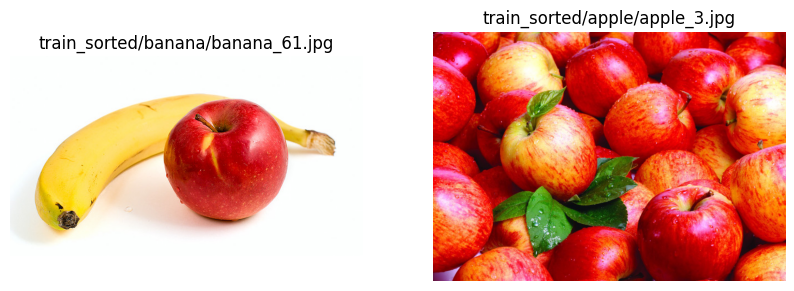

In [ ]:
# Showing the images that are potential outliers or wrongly labelled
UmapwrongImageList = ["train_sorted/banana/banana_61.jpg","train_sorted/apple/apple_3.jpg"]

# Plotting the images
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

for i,filepath in enumerate(UmapwrongImageList):
    image = mpimg.imread(filepath)
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(filepath)

In [ ]:
# Excluding outliers
outliers = wrongImageList + UmapwrongImageList

# Creating a dataframe to facilitate the flow_from_dataframe function for the ImageDataGenerator
imagedata = []
row = 0
for classname in os.listdir("train_sorted"):
    classpath = os.path.join("train_sorted", classname)
    for imagepath in os.listdir(classpath):
        imagerelativepath = os.path.join(classname,imagepath)
        if ("train_sorted/" + imagerelativepath) not in outliers:
            imagedata.append([imagerelativepath, classname])


imagedataframe = pd.DataFrame(data= imagedata, columns=("pathname","class"))

In [ ]:
cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=imagedataframe,
    directory="train_sorted",
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=imagedataframe,
    directory="train_sorted",
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)


Found 189 validated image filenames belonging to 4 classes.
Found 47 validated image filenames belonging to 4 classes.


#### 3. Generating more images to improve training of model

Generating more images from the datasets allows the model to be more robust, learning more the features that are more 'important'.

In [ ]:
# Defining our augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:

trainDataSet = datagen.flow_from_directory(target_size=(image_height, image_width),directory=r"train_sorted",batch_size=32,class_mode="categorical")

Found 240 images belonging to 4 classes.


In [ ]:
trainDataSet.samples

240

In [ ]:
trainDataSet, validDataSet = generateTrainValidSets(datagen)

### Using MobileNet for prediction and baseline

Next, we will use the MobileNet and its existing weight to check for improvements

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
# Calling MobileNet
image_height, image_width = (224,224)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Adding the last dense and softmax layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

# Building the model
model = Model(inputs=base_model.input, outputs=x)

# Ensuring that the previous weights from the MobileNet is not trainable
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary(line_length = 100)

Model: "model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_1 (InputLayer)                        [(None, 224, 224, 3)]                   0              
                                                                                                    
 conv1 (Conv2D)                              (None, 112, 112, 32)                    864            
                                                                                                    
 conv1_bn (BatchNormalization)               (None, 112, 112, 32)                    128            
                                                                                                    
 conv1_relu (ReLU)                           (None, 112, 112, 32)                    0              
                                                                            

#### Training the model with train dataset

In [ ]:
# Training the model
num_epochs = 10
history = model.fit(
    trainDataSet,
    steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
    epochs = num_epochs,
    validation_data = validDataSet,
    validation_steps = validDataSet.samples // validDataSet.batch_size
)

Epoch 1/10
 5/24 [=====>........................] - ETA: 11s - loss: 2.8952 - accuracy: 0.3750  

c:\Users\Calvin\anaconda3\envs\gdipsa\lib\site-packages\PIL\Image.py:970: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



24/24 [==============================] - 23s 760ms/step - loss: 0.9914 - accuracy: 0.7243 - val_loss: 0.1584 - val_accuracy: 0.9500
Epoch 2/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0717 - accuracy: 0.9784 - val_loss: 0.1064 - val_accuracy: 0.9750
Epoch 3/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0469 - accuracy: 0.9838 - val_loss: 0.1232 - val_accuracy: 0.9250
Epoch 4/10
24/24 [==============================] - 12s 511ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9250
Epoch 5/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 0.9250
Epoch 6/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1468 - val_accuracy: 0.9500
Epoch 7/10
24/24 [==============================] - 12s 476ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9750
Epoch 8/10

#### Gettinng predictions for test dataset

In [ ]:
# Sorting test images into their folders
make_folders("test_sorted")
testpath = os.listdir('test')
for i in testpath:
    match = re.match(pattern, i)
    if match:
        result = match.group()
    shutil.copy("test/" + i, "test_sorted/" + result)



# Getting accuracy score for test data set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "test_sorted",
    target_size=(image_height, image_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Predict on the entire generator
predictions = model.predict(test_generator, steps=test_generator.samples)



Found 60 images belonging to 4 classes.
60/60 [==============================] - 5s 72ms/step


#### Finding the accuracy for test dataset

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples)

NameError: name 'test_generator' is not defined

##### It observed that the model is slightly overfitted where the training accuracy is at **1.00** and the test is at **0.95**

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(true_classes,predicted_classes, average='macro')

0.9108285917496444